# Water Quality Prediction
Author(s): Amy Ou, Bryan Flores, Trevor Sauerbrey

In [1]:
''' Dependencies '''
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import time
from tabulate import tabulate
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as IPImage, display
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.impute import SimpleImputer

In [19]:
''' Import CSV '''
water = pd.read_csv('./data/water_potability.csv')
water

ph    Hardness        Solids  Chloramines     Sulfate  \
0          NaN  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246         NaN   
2     8.099124  224.236259  19909.541732     9.275884         NaN   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
9823  4.668102  193.681735  47580.991603     7.166639  359.948574   
9824  7.808856  193.553212  17329.802160     8.061362         NaN   
9825  9.419510  175.762646  33155.578218     7.350233         NaN   
9826  5.126763  230.603758  11983.869376     6.303357         NaN   
9827  7.874671  195.102299  17404.177061     7.509306         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
9823    526.424171       13.894419        66.687695   4.435821           1  
9824    392.449580       19.903225              NaN   2.798243           1  
9825    432.044783       11.039070        69.845400   3.298875           1  
9826    402.883113       11.168946        77.488213   4.708658           1  
9827    327.459760       16.140368        78.698446   2.309149           1  

[9828 rows x 10 columns]

# Exploratory Analysis

## Summary statistics

Dataset Shape: (3276, 10)


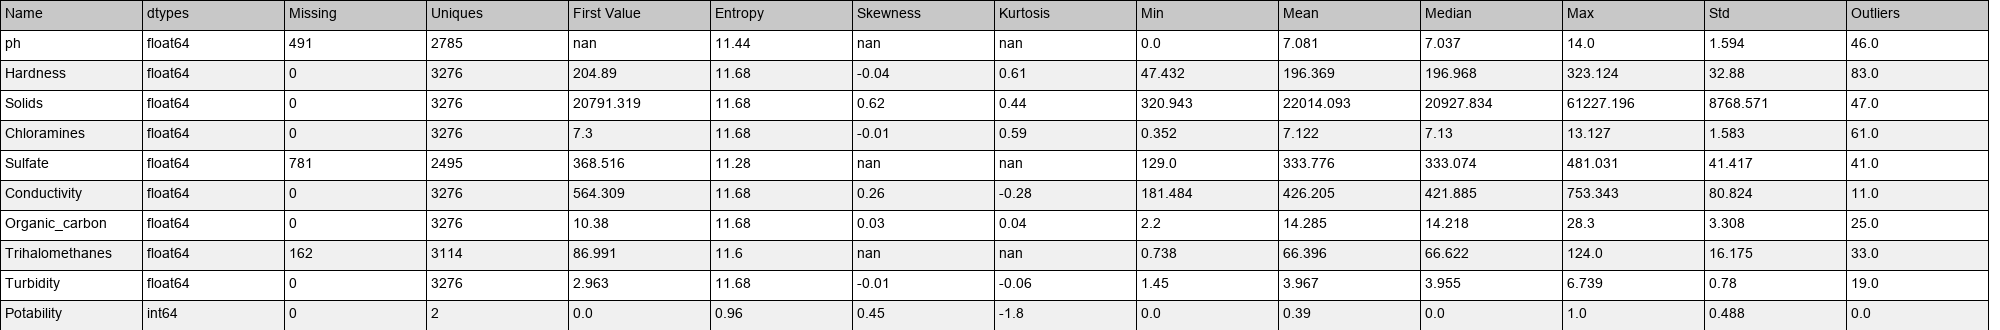

In [3]:
def analyze_data(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

        if df[name].dtype in ['float64', 'int64']:
            summary.loc[summary['Name'] == name, 'Skewness'] = round(stats.skew(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Kurtosis'] = round(stats.kurtosis(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Min'] = df[name].min()
            summary.loc[summary['Name'] == name, 'Mean'] = df[name].mean()
            summary.loc[summary['Name'] == name, 'Median'] = df[name].median()
            summary.loc[summary['Name'] == name, 'Max'] = df[name].max()
            summary.loc[summary['Name'] == name, 'Std'] = df[name].std()

            # Outlier detection using IQR
            Q1 = df[name].quantile(0.25)
            Q3 = df[name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[name] < Q1 - 1.5 * IQR) | (df[name] > Q3 + 1.5 * IQR)]
            summary.loc[summary['Name'] == name, 'Outliers'] = len(outliers)

    return summary

# Analyze the 'water' dataset and store the summary
summary = analyze_data(water)

# Rounding all numeric columns to three decimals
numeric_cols = ['Missing', 'Uniques', 'First Value', 'Entropy', 'Skewness', 'Kurtosis',
                'Min', 'Mean', 'Median', 'Max', 'Std', 'Outliers']
summary[numeric_cols] = summary[numeric_cols].round(3)

# Formatting the summary DataFrame for tabulation
summary_table = summary[['Name', 'dtypes', 'Missing', 'Uniques', 'First Value', 'Entropy', 
                         'Skewness', 'Kurtosis', 'Min', 'Mean', 'Median', 'Max', 'Std', 'Outliers']]

# Define image dimensions and font settings
table_width = 2000  # Increased table width
table_height = 400
font_size = 14  # Increased font size
font = ImageFont.truetype("arial.ttf", font_size)

# Create a new image
table_image = Image.new('RGB', (table_width, table_height), color='white')
draw = ImageDraw.Draw(table_image)

# Define cell dimensions
cell_width = table_width // len(summary_table.columns)
cell_height = 30

# Calculate the actual height required for the table
actual_table_height = (len(summary_table) + 1) * cell_height  # +1 for header row

# Create a new image with the actual table height
table_image = Image.new('RGB', (table_width, actual_table_height), color='white')
draw = ImageDraw.Draw(table_image)

# Draw table header
header_fill = (200, 200, 200)
header_text_color = (0, 0, 0)
for col_idx, column in enumerate(summary_table.columns):
    draw.rectangle([col_idx * cell_width, 0, (col_idx + 1) * cell_width, cell_height], outline='black', fill=header_fill)
    draw.text((col_idx * cell_width + 5, 5), column, fill=header_text_color, font=font)

# Draw table rows
row_fill = [(255, 255, 255), (240, 240, 240)]
for row_idx, (_, row) in enumerate(summary_table.iterrows()):
    for col_idx, (col_name, value) in enumerate(row.iteritems()):
        cell_text = str(value)
        cell_fill = row_fill[row_idx % 2]
        draw.rectangle([col_idx * cell_width, (row_idx + 1) * cell_height, (col_idx + 1) * cell_width, (row_idx + 2) * cell_height], outline='black', fill=cell_fill)
        draw.text((col_idx * cell_width + 5, (row_idx + 1) * cell_height + 5), cell_text, fill='black', font=font)

# Save the image to the "plots" folder
output_folder = './plots'
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, 'summary_table.png')
table_image.save(output_path)
display(IPImage(output_path))

## Nan values

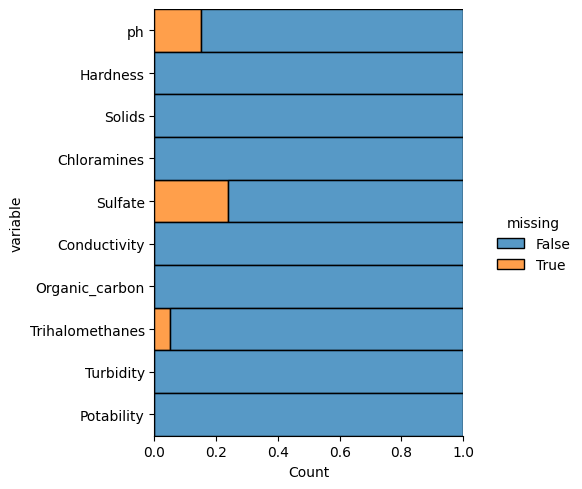

In [4]:
# Get counts of NaN and plot distribution of missing values
sns.displot(data=water.isna().melt(value_name='missing'), y='variable', hue='missing',
            multiple='fill', aspect=1
            )
plt.show()

## Distribution of Predictor Variables & Skewness/Kurtosis

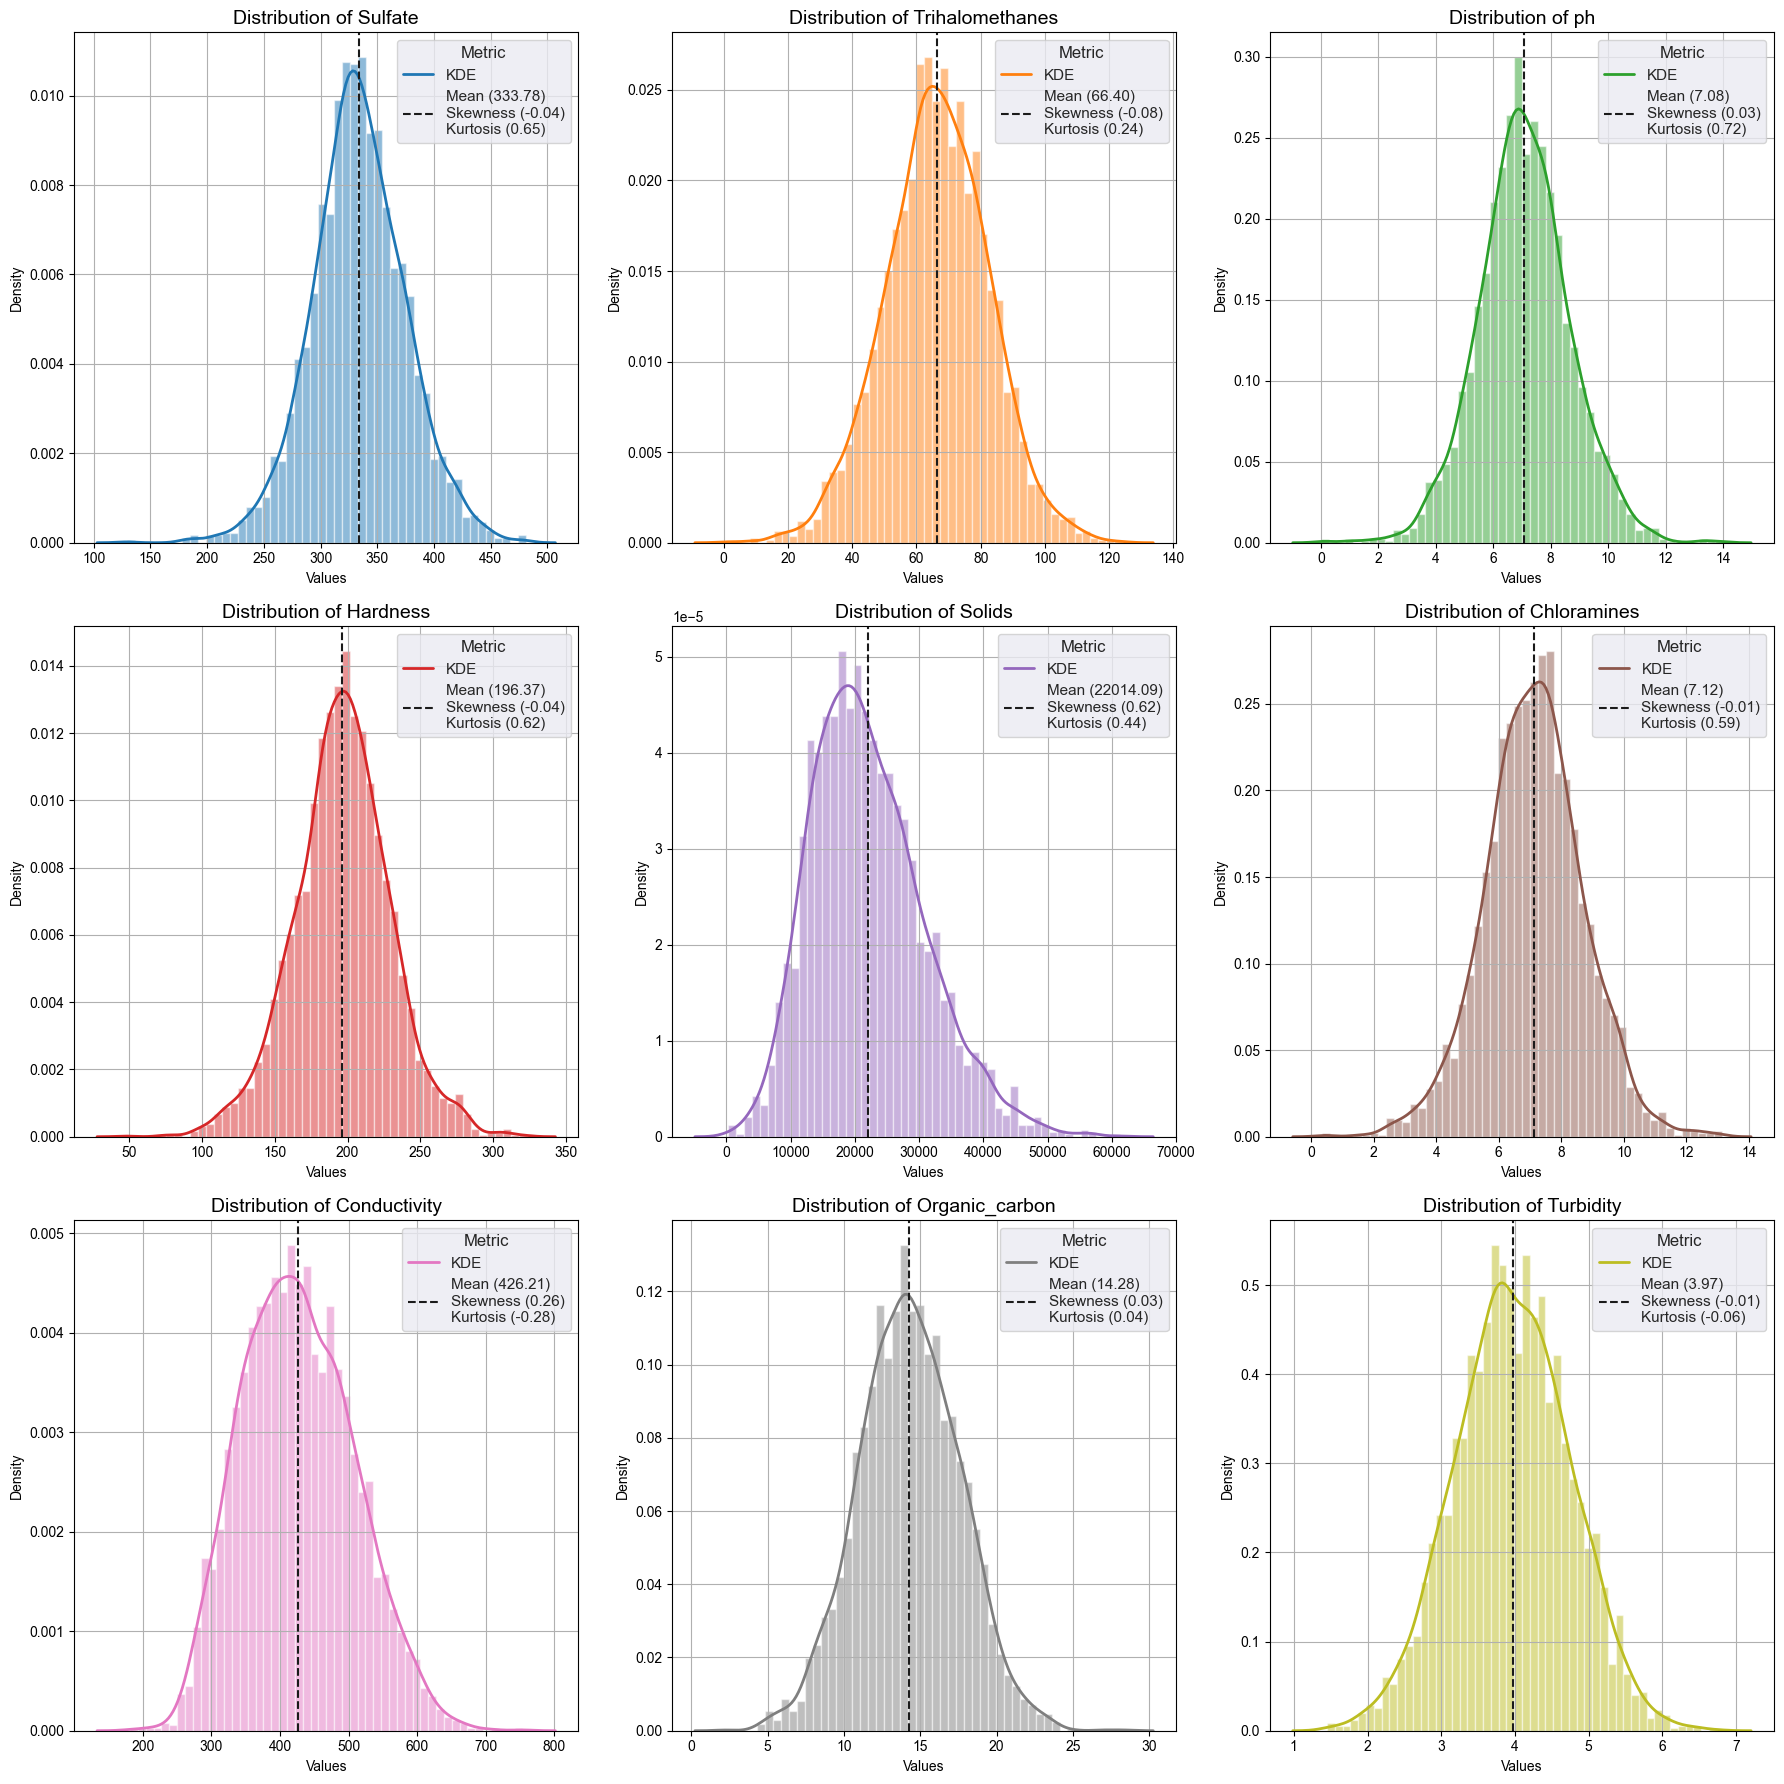

In [5]:
# Columns to plot
columns_to_plot = ['Sulfate', 'Trihalomethanes', 'ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Turbidity']

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
sns.set(style="darkgrid")

# Use Tab10 colors
tab10_colors = sns.color_palette("tab10")
colors = tab10_colors

for i, (column, color) in enumerate(zip(columns_to_plot, colors)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    water_miss_vals = water[[column]]
    labels = [column]
    
    # Calculate mean value
    mean_value = water_miss_vals.mean().values[0]
    
    # Calculate skewness
    skewness = water_miss_vals[column].skew()
    
    # Calculate kurtosis
    kurtosis = water_miss_vals[column].kurtosis()
    
    # Histogram with KDE Overlay
    ax.hist(water_miss_vals[column], bins=50, color=color, alpha=0.5, density=True)  # Plot histogram bars
    sns.kdeplot(data=water_miss_vals, x=column, color=color, ax=ax, linewidth=2, label=f'KDE')  # Overlay KDE plot
    
    # Plot mean value, skewness, and kurtosis
    ax.axvline(x=mean_value, color='k', linestyle='--', label=f'Mean ({mean_value:.2f})\nSkewness ({skewness:.2f})\nKurtosis ({kurtosis:.2f})')
    
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {column}', fontsize=14)
    ax.legend(title='Metric', loc='upper right')  # Include mean, skewness, and kurtosis in the legend
    ax.grid(True)

plt.tight_layout()

# Save the plot to the "plots" folder
output_folder = './plots/'
output_filename = 'feature_distributions.png'
output_path = output_folder + output_filename
plt.savefig(output_path)
plt.show()
plt.close()

## Correlation Matrix

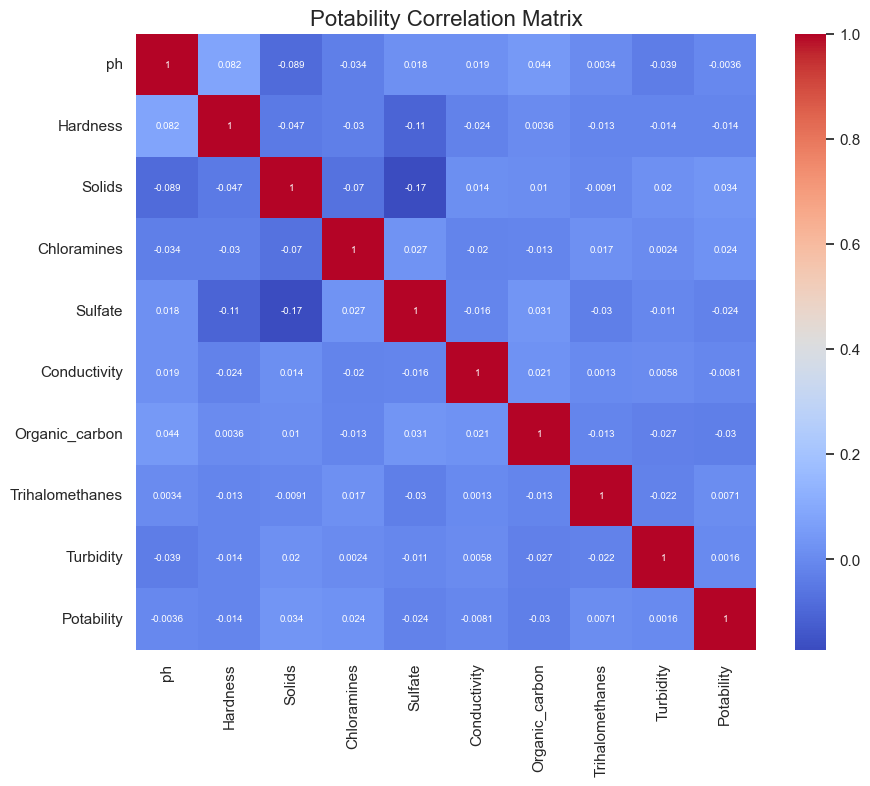

In [6]:
# Create the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=water.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 7})
plt.title('Potability Correlation Matrix', size=16)

# Save the correlation matrix heatmap to the "plots" folder
output_folder = './plots/'
output_filename = 'correlation_matrix.png'
output_path = output_folder + output_filename
plt.savefig(output_path)
plt.show()
plt.close()

## Pairplot by Potability

<Figure size 1200x1000 with 0 Axes>

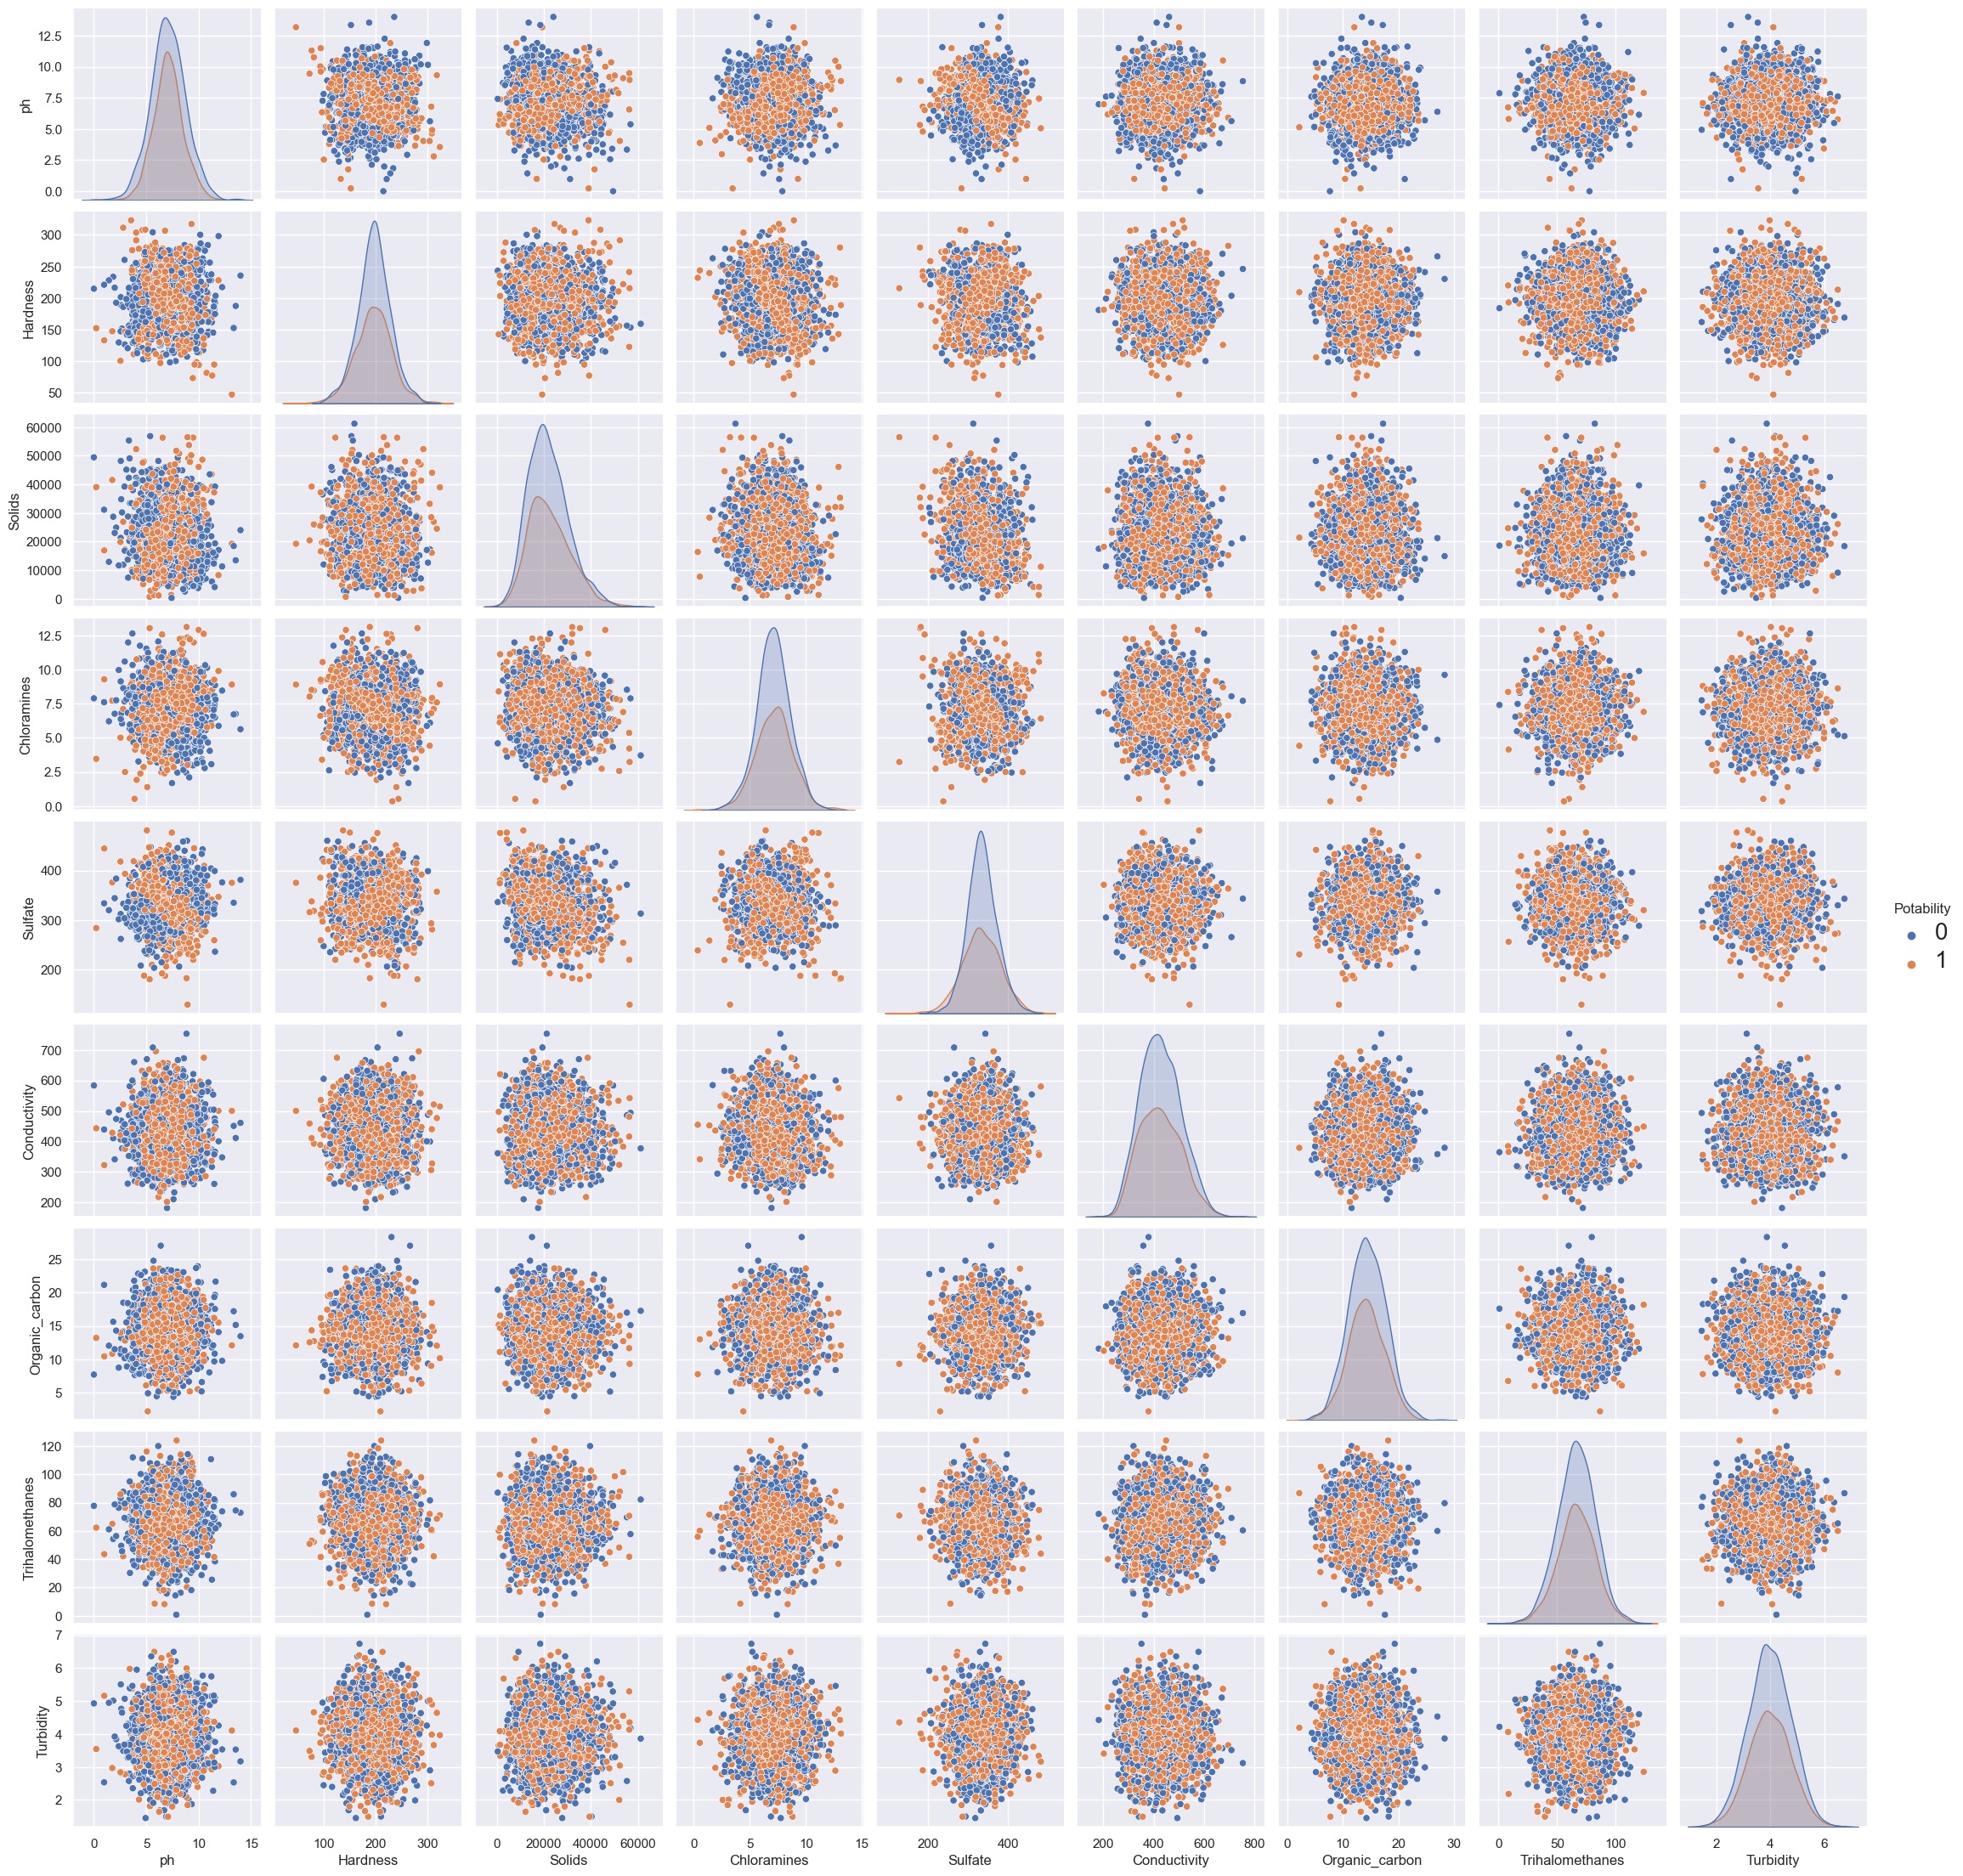

In [14]:
# Create the pair plot
plt.figure(figsize=(12, 10))
pair_plot = sns.pairplot(water, hue='Potability')

# Access the legend properties and adjust settings
legend = pair_plot._legend
legend.set_title('Potability')  
legend.get_frame().set_facecolor('white')  
for text in legend.get_texts():
    text.set_fontsize(20)  

# Save the pair plot to the "plots" folder
output_folder = './plots/'
output_filename = 'pair_plot.png'
output_path = output_folder + output_filename
plt.savefig(output_path)
plt.show()
plt.close()

## Box & Whisker plots & outliers by Potability

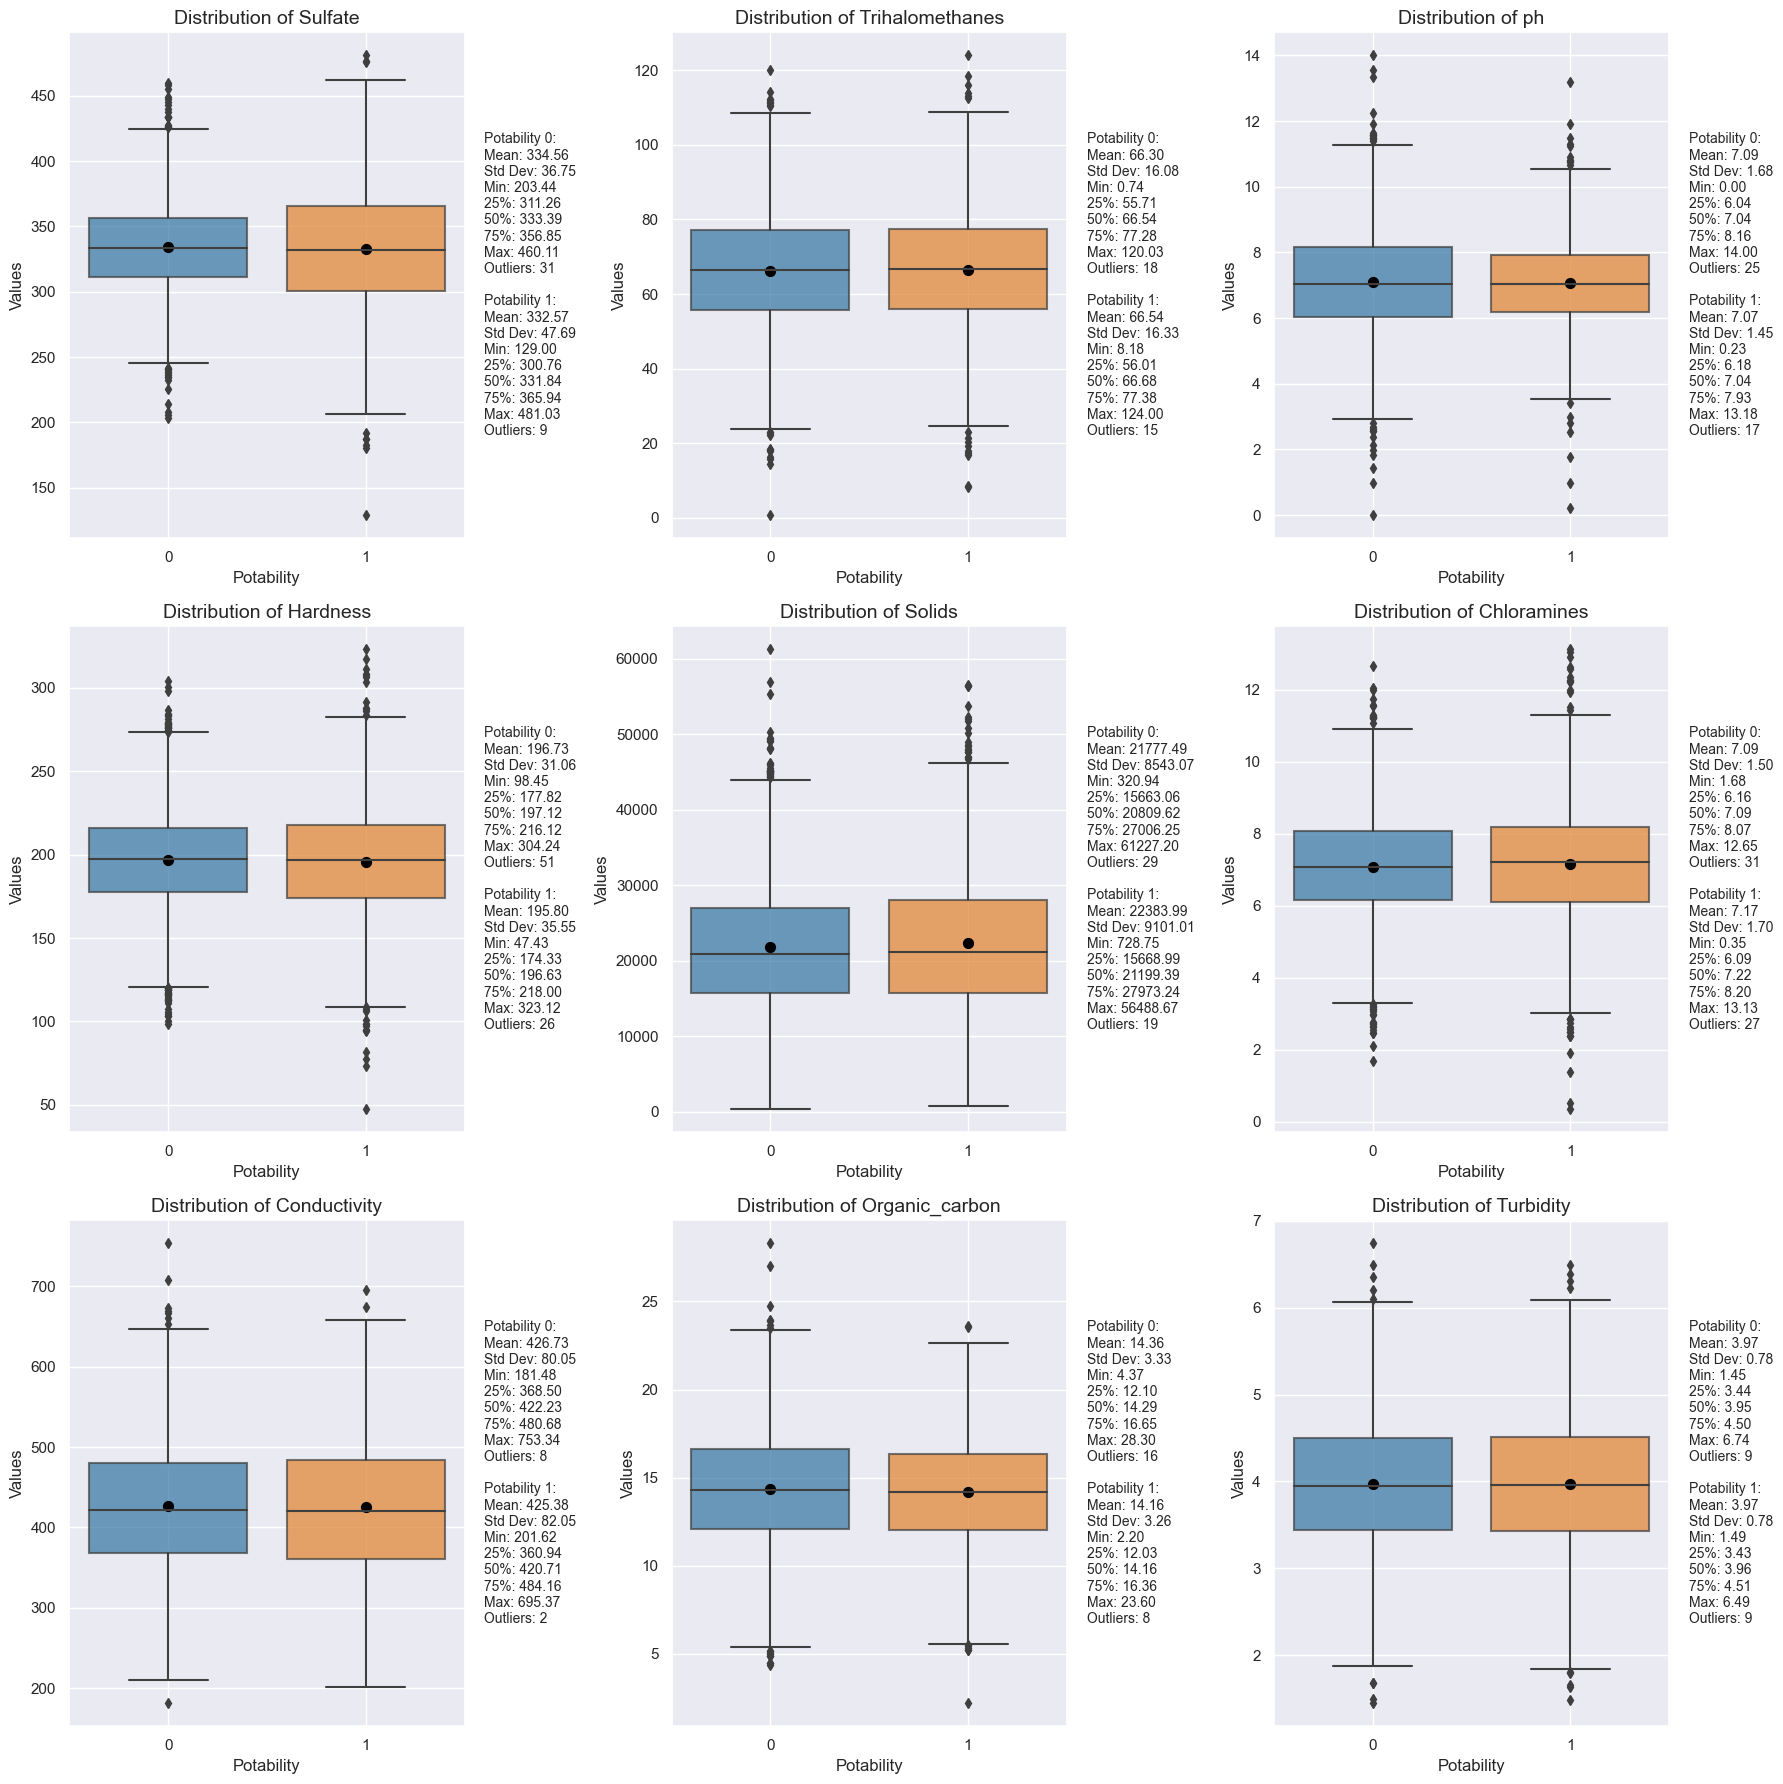

In [15]:
# Use Seaborn's Tab20 color palette
tab20_colors = sns.color_palette("tab10")

# Columns to plot
columns_to_plot = ['Sulfate', 'Trihalomethanes', 'ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Turbidity']

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
sns.set(style="darkgrid")

# Use Tab20 colors
colors = tab20_colors

for i, (column, color) in enumerate(zip(columns_to_plot, colors)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Box and whisker plot with potability as hue
    sns.boxplot(data=water, x='Potability', y=column, ax=ax, palette=[colors[0], colors[1]], showfliers=True)
    
    # Set box transparency using the set_alpha() method
    for patch in ax.patches:
        patch.set_alpha(0.7)  # Set alpha value here
    
    # Add a scatter plot for mean values
    mean_value = water.groupby('Potability')[column].mean()
    ax.scatter(x=[0, 1], y=mean_value, color='black', marker='o', s=50, label='Mean')
    
    # Set title
    ax.set_title(f'Distribution of {column}', fontsize=14)
    
    # Set y-axis label
    ax.set_ylabel('Values')
    
    # Set grid
    ax.grid(True)
    
    # Get summary metrics using describe()
    summary_metrics = water.groupby('Potability')[column].describe()
    
    # Calculate the number of outliers for each Potability value
    Q1_0 = summary_metrics.loc[0, '25%']
    Q3_0 = summary_metrics.loc[0, '75%']
    IQR_0 = Q3_0 - Q1_0
    lower_bound_0 = Q1_0 - 1.5 * IQR_0
    upper_bound_0 = Q3_0 + 1.5 * IQR_0
    outlier_count_0 = len(water[(water['Potability'] == 0) & ((water[column] < lower_bound_0) | (water[column] > upper_bound_0))])
    
    Q1_1 = summary_metrics.loc[1, '25%']
    Q3_1 = summary_metrics.loc[1, '75%']
    IQR_1 = Q3_1 - Q1_1
    lower_bound_1 = Q1_1 - 1.5 * IQR_1
    upper_bound_1 = Q3_1 + 1.5 * IQR_1
    outlier_count_1 = len(water[(water['Potability'] == 1) & ((water[column] < lower_bound_1) | (water[column] > upper_bound_1))])
    
    # Create formatted legends for each Potability value
    legend_text_stats = f"Potability 0:\n" \
                        f"Mean: {summary_metrics.loc[0, 'mean']:.2f}\n" \
                        f"Std Dev: {summary_metrics.loc[0, 'std']:.2f}\n" \
                        f"Min: {summary_metrics.loc[0, 'min']:.2f}\n" \
                        f"25%: {summary_metrics.loc[0, '25%']:.2f}\n" \
                        f"50%: {summary_metrics.loc[0, '50%']:.2f}\n" \
                        f"75%: {summary_metrics.loc[0, '75%']:.2f}\n" \
                        f"Max: {summary_metrics.loc[0, 'max']:.2f}\n" \
                        f"Outliers: {outlier_count_0}"
    
    legend_text_stats += f"\n\nPotability 1:\n" \
                         f"Mean: {summary_metrics.loc[1, 'mean']:.2f}\n" \
                         f"Std Dev: {summary_metrics.loc[1, 'std']:.2f}\n" \
                         f"Min: {summary_metrics.loc[1, 'min']:.2f}\n" \
                         f"25%: {summary_metrics.loc[1, '25%']:.2f}\n" \
                         f"50%: {summary_metrics.loc[1, '50%']:.2f}\n" \
                         f"75%: {summary_metrics.loc[1, '75%']:.2f}\n" \
                         f"Max: {summary_metrics.loc[1, 'max']:.2f}\n" \
                         f"Outliers: {outlier_count_1}"
    
    # Display the summary stats outside the plot
    ax.text(1.05, 0.5, legend_text_stats, transform=ax.transAxes, fontsize=10,
            verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Remove the existing legend from the subplots
for ax in axes.flatten():
    ax.legend().set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the plot to the "plots" folder
output_folder = './plots/'
output_filename = 'box_whisker_plots_with_metrics_by_target_potability.png'
output_path = output_folder + output_filename
plt.savefig(output_path)
plt.show()
plt.close()

## Target variable (Potability) Class Balance

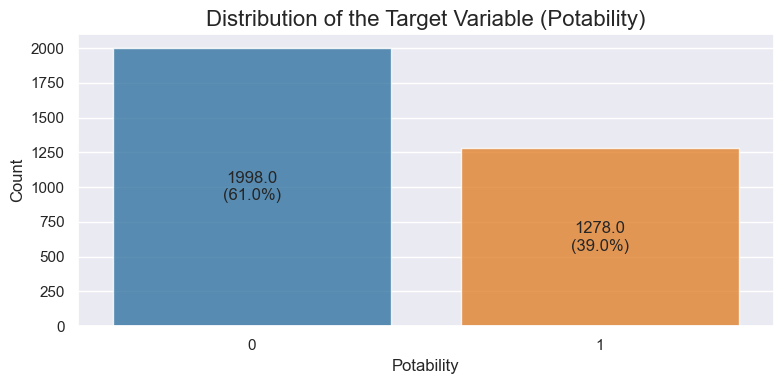

In [16]:
# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(8, 4))

# Create the count plot
graph = sns.countplot(ax=ax1, x='Potability', data=water, palette='tab10', alpha=0.8)
graph.set_xticklabels(graph.get_xticklabels(), rotation=0)  

# Add count and percentage text labels in the middle of the bars
total_count = len(water)
for p in graph.patches:
    height = p.get_height()
    count_label = f"{height}"
    percentage = (height / total_count) * 100
    percentage_label = f"({percentage:.1f}%)"
    label = f"{count_label}\n{percentage_label}"
    x = p.get_x() + p.get_width() / 2.
    y = height / 2
    graph.text(x, y, label, ha="center", va="center")

# Set title and labels
graph.set_title("Distribution of the Target Variable (Potability)", fontsize=16)
graph.set_xlabel("Potability")
graph.set_ylabel("Count")

# Save the plot to the "plots" folder within the repo
output_folder = './plots/'
os.makedirs(output_folder, exist_ok=True)
output_filename = 'potability_distribution.png'
output_path = os.path.join(output_folder, output_filename)
plt.savefig(output_path)

# Display the plot
plt.tight_layout()
plt.show()
plt.close()

## Dimensionality Reduction by PCA

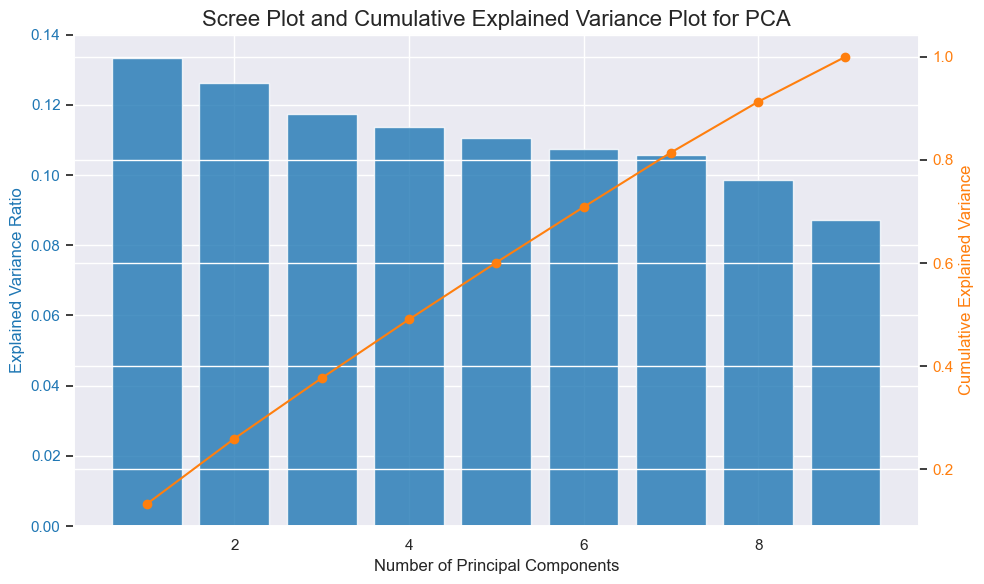

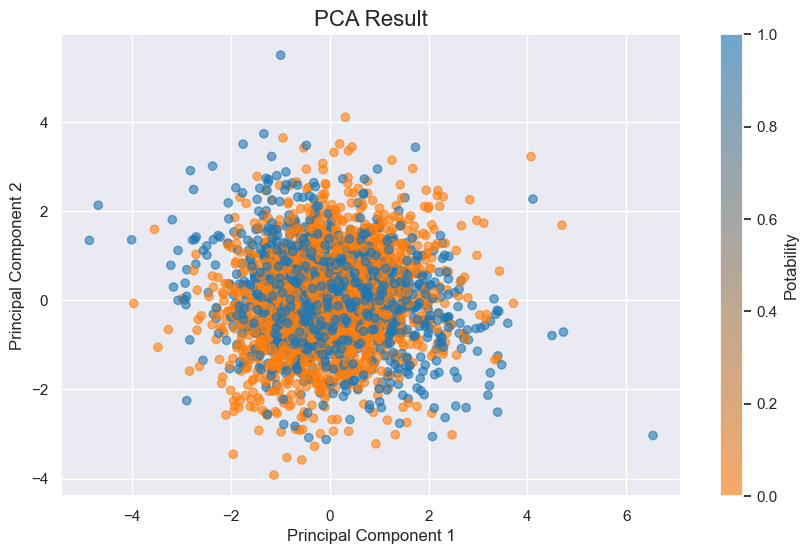

Feature Loadings on Principal Components:
                      PC1       PC2       PC3       PC4       PC5       PC6  \
ph              -0.314897 -0.552808 -0.085210 -0.005760 -0.196903 -0.081293   
Hardness         0.010587 -0.626197  0.369996 -0.205427 -0.040776  0.189254   
Solids           0.669256  0.057778 -0.187210  0.080522  0.198697  0.034898   
Chloramines     -0.254214  0.320848  0.360353  0.177319 -0.055970  0.721781   
Sulfate         -0.586589  0.308082 -0.256462 -0.116550  0.059792 -0.265198   
Conductivity     0.078598 -0.055649 -0.493046  0.183305 -0.709990  0.133093   
Organic_carbon  -0.106662 -0.200161 -0.558188  0.117811  0.323641  0.542177   
Trihalomethanes  0.008944  0.003602  0.253872  0.763388 -0.234540 -0.167867   
Turbidity        0.162720  0.240644  0.077776 -0.525372 -0.499540  0.158779   

                      PC7       PC8       PC9  
ph               0.117102  0.720529 -0.098462  
Hardness        -0.032748 -0.473780 -0.406999  
Solids           0.0192

In [17]:
# Assuming you have your preprocessed_data DataFrame
X = water.drop(columns=['Potability'])

# Replace NaN values with a placeholder (e.g., median) for PCA
X_filled = X.fillna(X.median())  # You can use other imputation methods if needed

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a figure with a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot scree plot (on left y-axis)
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, label='Explained Variance Ratio', color='#1f77b4')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create a second y-axis for cumulative explained variance
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='#ff7f0e', label='Cumulative Explained Variance')
ax2.set_ylabel('Cumulative Explained Variance', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

plt.title('Scree Plot and Cumulative Explained Variance Plot for PCA', fontsize=16)
fig.tight_layout()
plt.show()
plt.close()

# Select the number of components that explain a desired amount of variance
desired_variance = 0.95  # For example, you can choose 95% variance
num_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1

# Perform PCA again with the selected number of components
pca = PCA(n_components=num_components)
X_pca_final = pca.fit_transform(X_scaled)

# Visualize the data in the new PCA space (if desired)

# Create custom cmap
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#ff7f0e"],
          [norm( 1.0), "#1f77b4"]]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# For example, if num_components = 2
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_final[:, 0], X_pca_final[:, 1], c=water['Potability'], cmap=cmap, alpha=0.6)  # Using 'bwr' colormap
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result', fontsize=16)
plt.colorbar(label='Potability')
plt.savefig('plots/pca_result.png')
plt.show()
plt.close()

# You can also analyze the loadings of original features on each principal component
loadings = pca.components_.T  # Each column represents a principal component
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(num_components)], index=X_filled.columns)
print("Feature Loadings on Principal Components:")
print(loadings_df)

## T-test (F statistic and P-values)

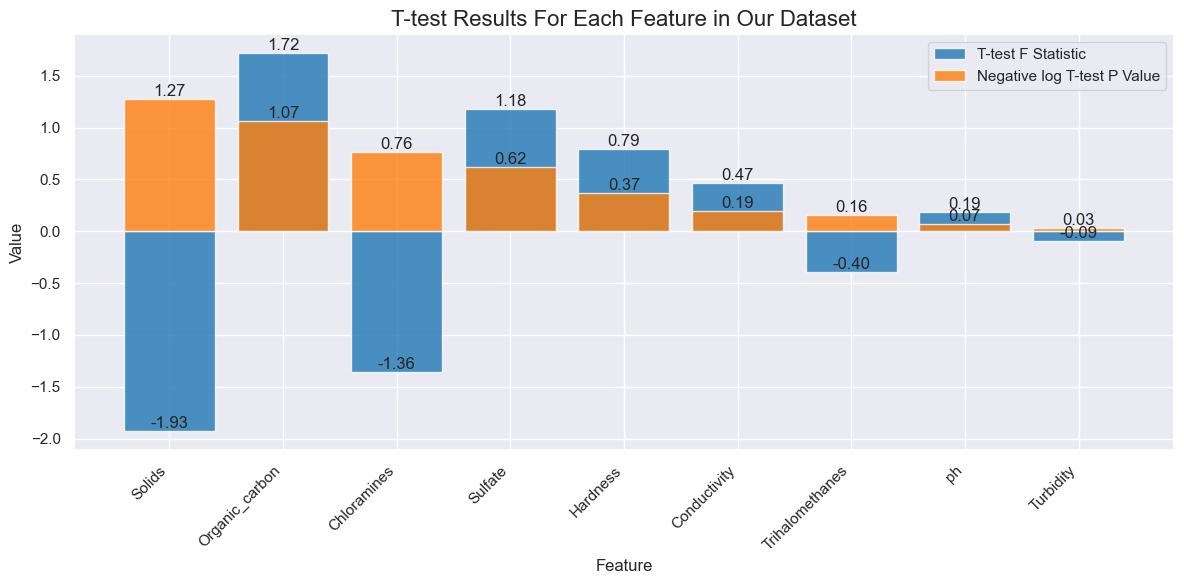

S         P                F
2 -1.931855  0.053464           Solids
6  1.717418  0.085997   Organic_carbon
3 -1.360991  0.173610      Chloramines
4  1.177528  0.239097          Sulfate
1  0.791788  0.428542         Hardness
5  0.465109  0.641885     Conductivity
7 -0.397782  0.690818  Trihalomethanes
0  0.187619  0.851189               ph
8 -0.090445  0.927939        Turbidity

In [11]:
ttest_results_pvalues = []
ttest_results_statistic = []
features = water.columns[water.columns != 'Potability']

# Separate the data based on class label
non_potable = water[water['Potability'] == 0]
potable = water[water['Potability'] == 1]

# Calculate t-test results for each feature
for col in features:
    # Calculate the mean for each group while ignoring NaN values
    mean_non_potable = np.nanmean(non_potable[col])
    mean_potable = np.nanmean(potable[col])
    
    # Calculate the t-test statistic and p-value
    statistic, pvalue = ttest_ind(non_potable[col], potable[col], nan_policy='omit')
    ttest_results_pvalues.append(pvalue)
    ttest_results_statistic.append(statistic)

# Create a DataFrame to store t-test results
ttest_res_df = pd.DataFrame({'S': ttest_results_statistic, 'P': ttest_results_pvalues, 'F': features})
ttest_res_df = ttest_res_df.sort_values(by='P')

# Create Matplotlib Bar plots
plt.figure(figsize=(12, 6))

# Plot F-statistic
bars1 = plt.bar(ttest_res_df['F'], ttest_res_df['S'], color='#1f77b4', alpha=0.8, label='T-test F Statistic')

# Plot P-values
bars2 = plt.bar(ttest_res_df['F'], -np.log10(ttest_res_df['P']), color='#ff7f0e', alpha=0.8, label='Negative log T-test P Value')

plt.title('T-test Results For Each Feature in Our Dataset', fontsize=16)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Add values on top of the bars
for bar1, bar2 in zip(bars1, bars2):
    value1 = bar1.get_height()
    value2 = bar2.get_height()
    plt.text(bar1.get_x() + bar1.get_width()/2, value1, f'{value1:.2f}', ha='center', va='bottom')
    plt.text(bar2.get_x() + bar2.get_width()/2, value2, f'{value2:.2f}', ha='center', va='bottom')

# Define the path to the plots folder within your repository
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'ttest_results_plot.png')
plt.savefig(plot_filename)
plt.show()
plt.close()
ttest_res_df

# Data Preprocessing and Preparation 

## Handling missing values, outliers and skewness

In [12]:
def preprocess_data(data, missing_method=None, outlier_method=None, knn_neighbors=5, lof_neighbors=20, lof_contamination=0.1, skewness_transform=None):
    """
    Preprocesses data by handling missing values, outliers, and skewness.

    Parameters:
        data (DataFrame): Input data with features and target.
        missing_method (str): Method for handling missing values ('drop', 'knn', or 'regression').
        outlier_method (str): Method for handling outliers ('iqr' or 'lof').
        knn_neighbors (int): Number of neighbors for KNN imputation.
        lof_neighbors (int): Number of neighbors for Local Outlier Factor.
        lof_contamination (float): Proportion of outliers expected in LOF.
        skewness_transform (str): Skewness transformation method ('log', 'boxcox', 'sqrt', 'cbrt').

    Returns:
        preprocessed_data (DataFrame): Preprocessed data after handling missing values, outliers, and skewness.
    """
    preprocessed_data = data.copy()
    
    # Handling missing values using KNN imputer
    if missing_method == 'drop':
        preprocessed_data.dropna(inplace=True)
    elif missing_method == 'knn':
        imputer = KNNImputer(n_neighbors=knn_neighbors)
        preprocessed_data = pd.DataFrame(imputer.fit_transform(preprocessed_data), columns=data.columns)
    elif missing_method == 'regression':
        for column in preprocessed_data.columns:
            incomplete_rows = preprocessed_data[preprocessed_data[column].isnull()]
            complete_rows = preprocessed_data[~preprocessed_data[column].isnull()]
            X_complete = complete_rows.drop(columns=[column])
            y_complete = complete_rows[column]
            regressor = RandomForestRegressor()  # Use any suitable regression model
            regressor.fit(X_complete, y_complete)
            imputed_values = regressor.predict(incomplete_rows.drop(columns=[column]))
            preprocessed_data.loc[preprocessed_data[column].isnull(), column] = imputed_values
    
    # Handling outliers using LOF
    if outlier_method == 'lof' and missing_method == 'knn':
        lof = LocalOutlierFactor(n_neighbors=lof_neighbors, contamination=lof_contamination)
        outlier_scores = lof.fit_predict(preprocessed_data)
        preprocessed_data = preprocessed_data[outlier_scores == 1]
    
    # Skewness transformation
    if skewness_transform == 'log':
        preprocessed_data = preprocessed_data.apply(lambda x: np.log1p(x))
    elif skewness_transform == 'boxcox':
        from scipy.stats import boxcox
        for column in preprocessed_data.columns:
            preprocessed_data[column] = boxcox(preprocessed_data[column] + 1)[0]
    elif skewness_transform == 'sqrt':
        preprocessed_data = preprocessed_data.apply(lambda x: np.sqrt(x))
    elif skewness_transform == 'cbrt':
        preprocessed_data = preprocessed_data.apply(lambda x: np.cbrt(x))
    
    return preprocessed_data

# Apply to only the predictor variables
predictor_var = water.drop(columns=['Potability'])

# Set parameters and process the data
preprocessed_data = preprocess_data(predictor_var, missing_method='drop', outlier_method=None, knn_neighbors=5, lof_neighbors=20, lof_contamination=0.1, skewness_transform='boxcox')

# Add the 'Potability' column back to the preprocessed data
preprocessed_data = preprocessed_data.copy()  # Make a copy of the preprocessed predictor variables
preprocessed_data['Potability'] = water['Potability']  # Add the 'Potability' column back
preprocessed_data

ph    Hardness      Solids  Chloramines     Sulfate  \
3      8.326112  479.841502  389.664722     8.412638  796.180201   
4      9.102890  393.470056  349.478433     6.804367  676.559524   
5      5.589198  411.966942  449.635919     7.864738  718.576340   
6     10.236534  569.814542  449.644552     7.831264  892.094699   
7      8.645732  450.968735  301.652427     4.710030  659.326086   
...         ...         ...         ...          ...         ...   
3267   9.000390  481.617413  327.386497     6.540184  683.634480   
3268   6.709305  461.319064  341.760311     8.038496  662.352383   
3269  11.506031  183.940019  516.213504     9.698155  548.859962   
3270   6.075426  407.712615  427.249078     8.080479  767.315129   
3271   4.671970  425.818865  589.127736     7.462532  804.108459   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3        24.347675       19.687395       133.161398   4.954528           0  
4        25.364675       12.199049        39.135988   4.340786           0  
5        21.693674        8.799461        69.763997   2.683539           0  
6        21.803760       14.617184       110.882404   2.806122           0  
7        27.399633       13.070581        80.545481   4.702057           0  
...            ...             ...              ...        ...         ...  
3267     25.137997       10.409497        69.970144   4.937931           1  
3268     23.306474       17.260691        35.073600   3.645189           1  
3269     26.498662       17.212073        51.761096   4.666394           1  
3270     25.850580       12.749925        77.280161   3.894040           1  
3271     28.674335       14.730961        85.905257   4.740213           1  

[2011 rows x 10 columns]

# Machine Learning

## Initial model testing with Decision Tree

In [32]:
X_Dtree = preprocessed_data.drop(columns=['Potability'])
y_Dtree = preprocessed_data['Potability']

X_train, X_test, y_train, y_test = train_test_split(X_Dtree, y_Dtree, test_size=0.2, random_state=42)

simple_imputer = SimpleImputer(strategy='mean')

imputed_Xtrain = simple_imputer.fit_transform(X_train)
imputed_Xtest = simple_imputer.transform(X_test)

# Choose and initialize a classification algorithm
dt = DecisionTreeClassifier(random_state=42)

# Train the classifier on the imputed training data
dt.fit(imputed_Xtrain, y_train)

# Predict the target values using the trained classifier
pred_y = dt.predict(imputed_Xtest)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, pred_y)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.63


## (Model Preparation, Parameter Optimization, Feature Importance & Model Performances

In [26]:
# Define a dictionary mapping sampling techniques to their corresponding resampling objects
resampling_methods = {
    'oversample': RandomOverSampler,
    'smote': SMOTE,
    'adasyn': ADASYN,
    'undersample': RandomUnderSampler,
    'resample': resample  
}

def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test, 
                                  scaling_method=None, sampling_technique=None, threshold=0.5):
    """
    Train and evaluate each classification model and evaluate their performancec. 

    Parameters:
        classifier: Classifier instance to train and evaluate.
        X_train: Training data features.
        y_train: Training data target.
        X_test: Testing data features.
        y_test: Testing data target.
        scaling_method (str): Method for scaling the data ('standard', 'minmax', or 'robust').
        sampling_technique (str): Method for applying sampling to handle class imbalance.
        threshold (float): Threshold value for converting probabilities to binary predictions.

    Returns:
        accuracy (float): Accuracy of the classifier.
        precision (float): Precision of the classifier.
        recall (float): Sensitivity/Recall of the classifier.
        specificity (float): Specificity of the classifier.
        roc_auc (float): ROC AUC score of the classifier.
        elapsed_time (float): Time taken for training and evaluation.
        feature_importances (pd.Series or None): Feature importances (if available).
        y_pred_probs (numpy.array): Predicted probabilities for the positive class.
    """
        
    start_time = time.time()

    if sampling_technique in resampling_methods:
        resampler = resampling_methods[sampling_technique](sampling_strategy='auto', random_state=42)
        X_train, y_train = resampler.fit_resample(X_train, y_train)

    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_method == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    classifier.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Obtain predicted probabilities for the positive class
    y_pred_probs = classifier.predict_proba(X_test)[:, 1]

    # Adjust the threshold to convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_test, y_pred_probs)

    feature_importances = None
    if hasattr(classifier, 'feature_importances_'):
        feature_importances = pd.Series(classifier.feature_importances_, index=X.columns)
        
    return accuracy, precision, recall, specificity, roc_auc, elapsed_time, feature_importances, y_pred_probs

# Declare target variable and predictor variables
X = preprocessed_data.drop(columns=['Potability'])
y = preprocessed_data['Potability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 250, 500],  # Standard: 100
        'max_depth': [None, 10, 20],      # Standard: None
        'min_samples_split': [2, 5, 10],  # Standard: 2
        'min_samples_leaf': [1, 2, 4],    # Standard: 1
        'max_features': ['auto', 'sqrt', 'log2']  # Standard: 'auto'
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [None, 10, 20],          # Standard: None
        'min_samples_split': [2, 5, 10],      # Standard: 2
        'min_samples_leaf': [1, 2, 4],        # Standard: 1
        'max_features': ['auto', 'sqrt', 'log2']  # Standard: None
    }),
    # This model takes WAY too long to run... which is why it is commented out
    # 'SVM': (SVC(kernel='linear', random_state=42, probability=True), {
    #     'C': [0.1, 1, 10],               # Standard: 1
    #     'gamma': ['scale', 'auto', 0.1, 1],   # Standard: 'scale'
    # }),
    'XGBoost': (XGBClassifier(random_state=42), {
        'n_estimators': [50, 100, 150],  # Standard: 100
        'max_depth': [3, 5, 7],           # Standard: 3
        'learning_rate': [0.01, 0.1, 0.2],  # Standard: 0.3
        'subsample': [0.8, 1.0],          # Standard: 1.0
        'colsample_bytree': [0.8, 1.0],   # Standard: 1.0
        'gamma': [0, 1, 5]                # Standard: 0
    }),
    'Neural Network': (MLPClassifier(hidden_layer_sizes=(100,), random_state=42), {
        'hidden_layer_sizes': [(50,), (100,), (150,)],  # Standard: (100,)
        'activation': ['relu', 'logistic'],            # Standard: 'relu'
        'alpha': [0.0001, 0.001, 0.01],                 # Standard: 0.0001
        'learning_rate': ['constant', 'adaptive'],      # Standard: 'constant'
    }),
    'Logistic Regression': (LogisticRegression(random_state=42), {
        'C': [0.1, 1, 10],             # Standard: 1
        'penalty': ['l1', 'l2'],       # Standard: 'l2'
        'solver': ['liblinear', 'lbfgs', 'saga']  # Standard: 'lbfgs'
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],       # Standard: 5
        'weights': ['uniform', 'distance'],  # Standard: 'uniform'
        'p': [1, 2]                     # Standard: 2
    }),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {
        'n_estimators': [50, 100, 150],  # Standard: 50
        'learning_rate': [0.1, 0.5, 1.0],  # Standard: 1.0
    }),
    'Naive Bayes': (GaussianNB(), {}),
    'Bagging Classifier': (BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42), {
        'n_estimators': [10, 20, 30],   # Standard: 10
        'max_samples': [0.5, 1.0],      # Standard: 1.0
        'max_features': [0.5, 1.0],     # Standard: 1.0
    }),
    'Quadratic Discriminant Analysis': (QuadraticDiscriminantAnalysis(), {}),
    'Linear Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
}

# Initialize dictionaries to store results and ROC AUC scores
results = {}
roc_auc_scores = {}

# To enable scaling, pass scaling_method='standard' or scaling_method='minmax'
# To disable scaling, pass scaling_method=None
# To use sampling, pass sampling_technique='oversample', 'smote', 'adasyn', or 'undersample'
# To use both scaling and sampling, pass both scaling_method and sampling_technique
# Train and evaluate each classifier with the desired processing method

threshold = 0.5  # Set the desired threshold value (can be any value between 0 and 1)
scaling_method = 'standard'
sampling_technique = 'adasyn'

# Initialize dictionaries to store results and ROC AUC scores
results = {}
roc_auc_scores = {}

for name, (classifier, param_grid) in tqdm(classifiers.items(), desc='Classifiers Progress'):
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_classifier = grid_search.best_estimator_

    # Train and evaluate the classifier as before
    accuracy, precision, recall, specificity, roc_auc, elapsed_time, feature_importances, y_pred_probs = train_and_evaluate_classifier(
        best_classifier, X_train, y_train, X_test, y_test,
        scaling_method=scaling_method,  
        sampling_technique=sampling_technique,  
        threshold=threshold)
    
    results[name] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity/Recall': recall,
        'Specificity': specificity,
        'ROC AUC': roc_auc,
        'Elapsed Time': elapsed_time,
        'Feature Importances': feature_importances,
        'y_pred_probs': y_pred_probs  # Store the predicted probabilities
    }
    
    # Store the ROC AUC score for later plotting
    roc_auc_scores[name] = roc_auc

    # Plot feature importances and save to the "plots" folder
    if feature_importances is not None:
        plt.figure(figsize=(10, 6))
        feature_importances.plot(kind='barh', color=cmap(0))  # Use the same color for all plots
        plt.xlabel('Feature Importance')
        plt.title(f'{name} - Feature Importances')
        plt.tight_layout()
        
        # Save the plot to the "plots" folder
        plots_folder = 'plots'
        if not os.path.exists(plots_folder):
            os.makedirs(plots_folder)
        plot_filename = os.path.join(plots_folder, f'{name}_feature_importance_plot.png')
        plt.savefig(plot_filename)
        plt.show()
        plt.close()

# Print results without numerical values
for name, metrics in results.items():
    print(f"{name} - Evaluation Metrics:")
    for metric, value in metrics.items():
        if metric == 'Feature Importances' or metric == 'y_pred_probs':
            continue  # Skip printing feature importances and y_pred_probs
        if metric == 'Elapsed Time':
            print(f"{metric}: {value:.4f} seconds")
        else:
            print(f"{metric}: {value}")
    print()

Classifiers Progress: 100%|██████████████| 11/11 [10:44<00:00, 58.56s/it]

Random Forest - Evaluation Metrics:
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy: 0.6178660049627791
Precision: 0.546875
Sensitivity/Recall: 0.6104651162790697
Specificity: 0.6233766233766234
ROC AUC: 0.6627655290445987
Elapsed Time: 13.6483 seconds

Decision Tree - Evaluation Metrics:
Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.5235732009925558
Precision: 0.45901639344262296
Sensitivity/Recall: 0.6511627906976745
Specificity: 0.42857142857142855
ROC AUC: 0.5621916842847076
Elapsed Time: 0.0800 seconds

XGBoost - Evaluation Metrics:
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.6104218362282878
Precision: 0.5336322869955157
Sensitivity/Recall: 0.6918604651162791
Specificity: 0.5497835497835498
ROC AUC: 0.6738648947951273
Elap

In [27]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Sensitivity/Recall', 'Specificity', 'ROC AUC', 'Elapsed Time', 'Best Parameters'])

# Save results to the DataFrame
for name, metrics in results.items():
    # Append the metrics to the DataFrame
    results_df = results_df.append({
        'Model': name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Sensitivity/Recall': metrics['Sensitivity/Recall'],
        'Specificity': metrics['Specificity'],
        'ROC AUC': metrics['ROC AUC'],
        'Elapsed Time': metrics['Elapsed Time'],
        'Best Parameters': metrics['Best Parameters']
    }, ignore_index=True)

# Create the "model_performance" folder if it doesn't exist
output_folder = 'model_performance_benchmarking'
os.makedirs(output_folder, exist_ok=True)

# Save the DataFrame to a CSV file
csv_file = os.path.join(output_folder, 'model_performance.csv')
results_df.to_csv(csv_file, index=False)

print(f"Saved model performance to {csv_file}")

results_df

Saved model performance to model_performance_benchmarking\model_performance.csv


Model  Accuracy  Precision  Sensitivity/Recall  \
0                     Random Forest  0.617866   0.546875            0.610465   
1                     Decision Tree  0.523573   0.459016            0.651163   
2                           XGBoost  0.610422   0.533632            0.691860   
3                    Neural Network  0.620347   0.546341            0.651163   
4               Logistic Regression  0.444169   0.413333            0.720930   
5               K-Nearest Neighbors  0.583127   0.508850            0.668605   
6                          AdaBoost  0.468983   0.423358            0.674419   
7                       Naive Bayes  0.526055   0.457778            0.598837   
8                Bagging Classifier  0.630273   0.560847            0.616279   
9   Quadratic Discriminant Analysis  0.637717   0.563107            0.674419   
10     Linear Discriminant Analysis  0.444169   0.413333            0.720930   

    Specificity   ROC AUC  Elapsed Time  \
0      0.623377  0.662766     13.648265   
1      0.428571  0.562192      0.079952   
2      0.549784  0.673865      0.490014   
3      0.597403  0.690728      4.916140   
4      0.238095  0.454294      0.062999   
5      0.519481  0.623150      0.070002   
6      0.316017  0.539162      2.436051   
7      0.471861  0.572486      0.029006   
8      0.640693  0.660563      1.000963   
9      0.610390  0.699361      0.036972   
10     0.238095  0.454294      0.040019   

                                      Best Parameters  
0   {'max_depth': 20, 'max_features': 'auto', 'min...  
1   {'max_depth': 10, 'max_features': 'auto', 'min...  
2   {'colsample_bytree': 1.0, 'gamma': 0, 'learnin...  
3   {'activation': 'relu', 'alpha': 0.001, 'hidden...  
4   {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}  
5    {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}  
6         {'learning_rate': 0.1, 'n_estimators': 150}  
7                                                  {}  
8   {'max_features': 1.0, 'max_samples': 0.5, 'n_e...  
9                                                  {}  
10                                                 {}

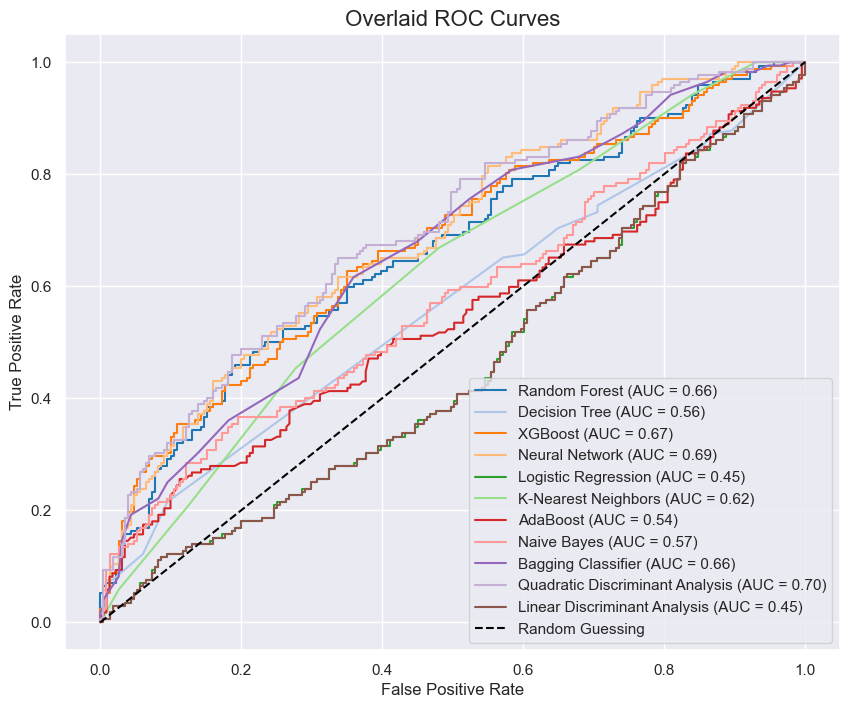

In [132]:
# Initialize an empty figure
plt.figure(figsize=(10, 8))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Plot the ROC curves for each model
for i, name in enumerate(roc_auc_scores.keys()):
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})', color=cmap(i))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overlaid ROC Curves', fontsize=16)
plt.legend()

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'overlaid_roc_curve.png')
plt.savefig(plot_filename)

# Show the plot
plt.show()

## Confusion Matrices

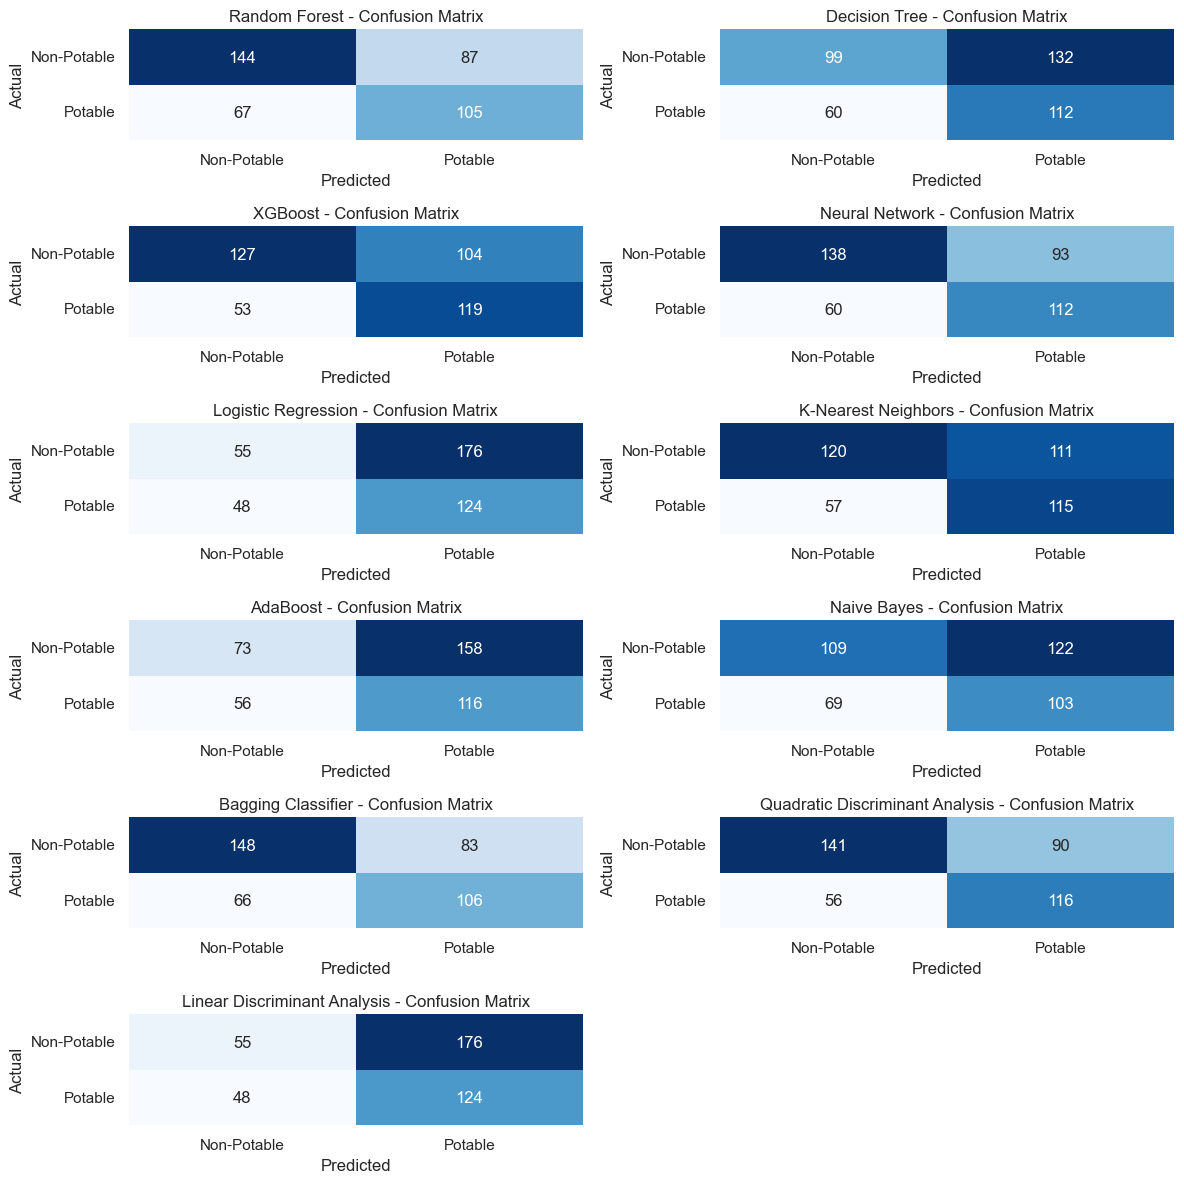

In [142]:
# Define the path to the plots folder
plots_folder = 'plots'

# Create the plots folder if it doesn't exist
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# Create a grid of confusion matrices
plt.figure(figsize=(12, 12))
grid_rows = len(classifiers) // 2 + len(classifiers) % 2
grid_cols = 2
sns.set(style="whitegrid")

for idx, (name, _) in enumerate(classifiers.items(), start=1):
    plt.subplot(grid_rows, grid_cols, idx)
    conf_matrix = confusion_matrix(y_test, results[name]['y_pred_probs'] > threshold)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Potable', 'Potable'], yticklabels=['Non-Potable', 'Potable'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()

# Save the combined plot
combined_plot_filename = os.path.join(plots_folder, 'confusion_matrix_combined.png')
plt.savefig(combined_plot_filename)
plt.show()

## Model Performance Metrics

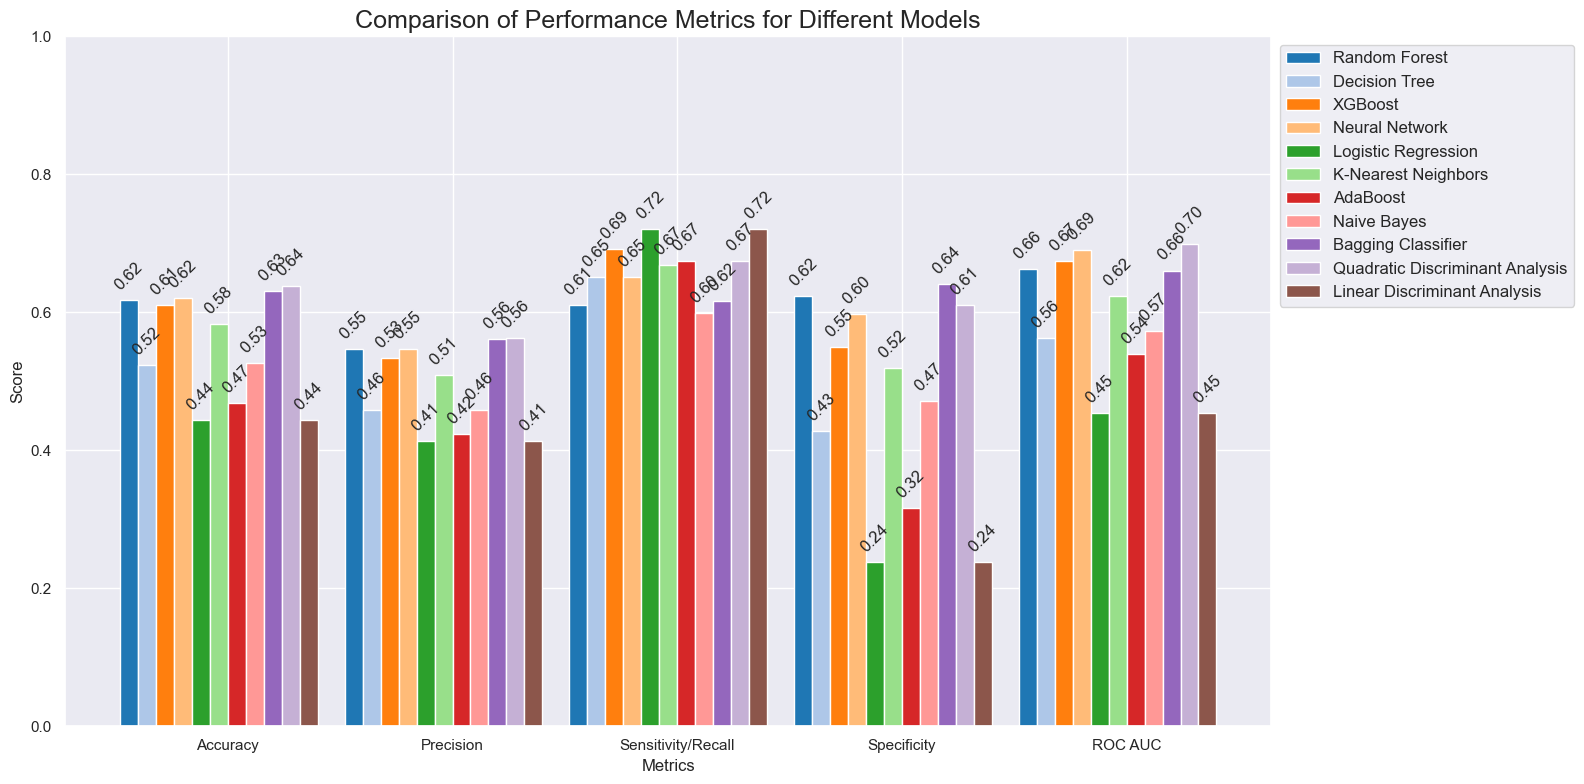

In [33]:
# List of metrics to include in the bar plot
metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity/Recall', 'Specificity', 'ROC AUC']

# Initialize a figure and axis
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Define the width of each group of bars
bar_width = 0.08

# Create an array of x positions for each set of bars
x_positions = np.arange(len(metrics_to_plot))

# Choose the 'tab20' colormap
cmap = cm.get_cmap('tab20')

# Iterate through each classifier and plot the metrics
for i, (name, metrics) in enumerate(results.items()):
    values = [metrics[metric] for metric in metrics_to_plot]
    x = x_positions + i * bar_width
    
    bars = ax.bar(x, values, width=bar_width, align='center', label=name, color=cmap(i))
    
    # Add metric values on top of each bar with rotation
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}',
                ha='center', va='bottom', rotation=45) 

# Configure plot settings
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Performance Metrics for Different Models', fontsize=18)
ax.set_xticks(x_positions + bar_width * len(results) / 2)
ax.set_xticklabels(metrics_to_plot)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 12})  
ax.set_ylim(0, 1)

# Save the plot to the "plots" folder
plots_folder = 'plots'
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
plot_filename = os.path.join(plots_folder, 'performance_metrics_comparison.png')
plt.savefig(plot_filename)

# Show the plot
plt.tight_layout()
plt.show()